In [3]:
!pip install speedtest-cli


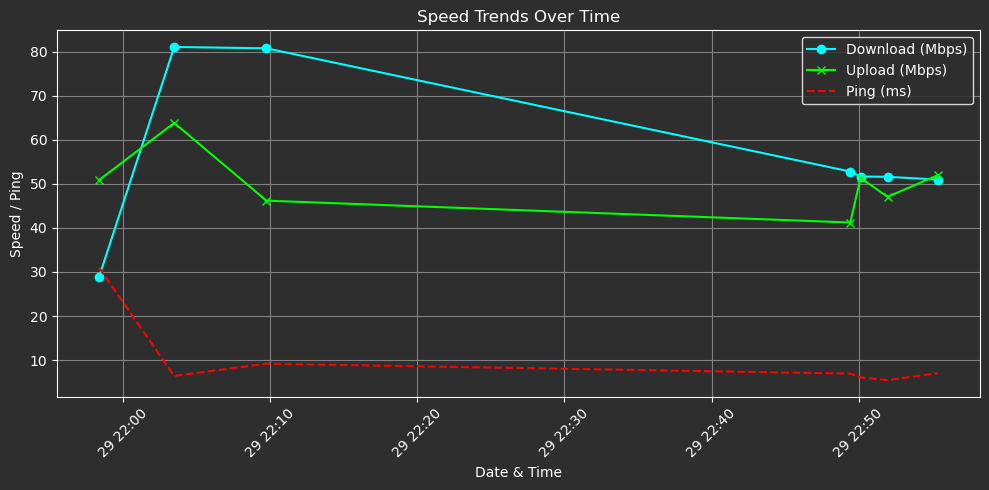

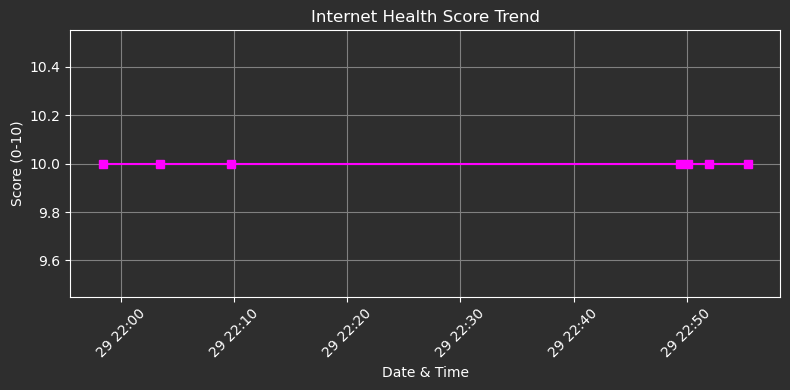

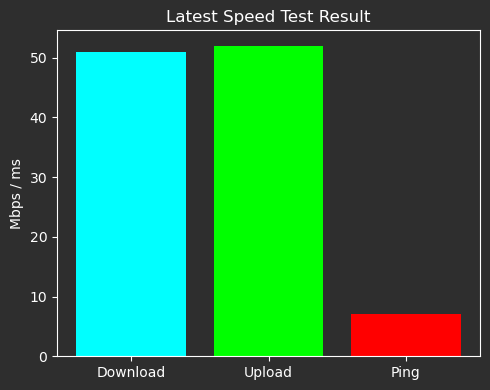

In [ ]:
import tkinter as tk
from tkinter import messagebox
import speedtest
import matplotlib.pyplot as plt
import matplotlib
import csv
import os
from datetime import datetime

LOG_FILE = "logs.csv"

# Apply dark theme to matplotlib
matplotlib.rcParams.update({
    'axes.facecolor': '#2e2e2e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'figure.facecolor': '#2e2e2e',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'legend.edgecolor': 'white',
    'grid.color': 'gray'
})

def calculate_health_score(ping, download, upload):
    # Basic scoring logic (tweakable)
    score = (download / 10) + (upload / 5) - (ping / 50)
    return round(min(10, max(0, score)), 2)

def run_speed_test():
    try:
        status_label.config(text="Running test... please wait")
        root.update_idletasks()

        st = speedtest.Speedtest()
        st.get_best_server()
        download = round(st.download() / 1_000_000, 2)
        upload = round(st.upload() / 1_000_000, 2)
        ping = round(st.results.ping, 2)

        health_score = calculate_health_score(ping, download, upload)

        result_label.config(text=f"Ping: {ping} ms\nDownload: {download} Mbps\nUpload: {upload} Mbps")
        score_label.config(text=f"Internet Health Score: {health_score} / 10")
        status_label.config(text="Test completed successfully")

        log_results(ping, download, upload, health_score)

    except Exception as e:
        messagebox.showerror("Error", f"Speed test failed:\n{str(e)}")
        status_label.config(text="Error during test")

def log_results(ping, download, upload, score):
    file_exists = os.path.isfile(LOG_FILE)
    with open(LOG_FILE, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(['Date', 'Ping (ms)', 'Download (Mbps)', 'Upload (Mbps)', 'Health Score'])
        writer.writerow([datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ping, download, upload, score])

def show_graph():
    if not os.path.exists(LOG_FILE):
        messagebox.showinfo("No Data", "No logs found. Please run a speed test first.")
        return

    dates, pings, downloads, uploads, scores = [], [], [], [], []

    with open(LOG_FILE, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            dates.append(datetime.strptime(row['Date'], '%Y-%m-%d %H:%M:%S'))
            pings.append(float(row['Ping (ms)']))
            downloads.append(float(row['Download (Mbps)']))
            uploads.append(float(row['Upload (Mbps)']))
            # Calculate Health Score
            score = (float(row['Download (Mbps)']) / 10) + (float(row['Upload (Mbps)']) / 5) - (float(row['Ping (ms)']) / 50)
            scores.append(min(10, max(0, round(score, 2))))

    # --- Line Chart: Download, Upload, Ping ---
    plt.figure(figsize=(10, 5))
    plt.plot(dates, downloads, label='Download (Mbps)', marker='o', color='cyan')
    plt.plot(dates, uploads, label='Upload (Mbps)', marker='x', color='lime')
    plt.plot(dates, pings, label='Ping (ms)', linestyle='--', color='red')
    plt.xlabel("Date & Time")
    plt.ylabel("Speed / Ping")
    plt.title("Speed Trends Over Time")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Line Chart: Internet Health Score ---
    plt.figure(figsize=(8, 4))
    plt.plot(dates, scores, label='Internet Health Score', marker='s', color='magenta')
    plt.xlabel("Date & Time")
    plt.ylabel("Score (0-10)")
    plt.title("Internet Health Score Trend")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Bar Chart: Last Test Only ---
    if dates:
        plt.figure(figsize=(5, 4))
        labels = ['Download', 'Upload', 'Ping']
        values = [downloads[-1], uploads[-1], pings[-1]]
        colors = ['cyan', 'lime', 'red']
        plt.bar(labels, values, color=colors)
        plt.title("Latest Speed Test Result")
        plt.ylabel("Mbps / ms")
        plt.tight_layout()
        plt.show()


# GUI Setup (Dark Mode)
root = tk.Tk()
root.title("Smart Network Speed Analyzer")
root.geometry("400x350")
root.configure(bg="#2e2e2e")

def style_button(btn):
    btn.configure(bg="#444", fg="#f0f0f0", activebackground="#555", activeforeground="white", relief=tk.FLAT)

title = tk.Label(root, text="Network Speed Analyzer", font=("Helvetica", 16, "bold"), bg="#2e2e2e", fg="#f0f0f0")
title.pack(pady=10)

btn_test = tk.Button(root, text="Run Speed Test", font=("Helvetica", 12), command=run_speed_test)
style_button(btn_test)
btn_test.pack(pady=10)

result_label = tk.Label(root, text="Click the button to start test", font=("Helvetica", 12), bg="#2e2e2e", fg="#f0f0f0")
result_label.pack(pady=10)

score_label = tk.Label(root, text="", font=("Helvetica", 12, "bold"), bg="#2e2e2e", fg="orange")
score_label.pack(pady=5)

btn_graph = tk.Button(root, text="Show Speed Trends", font=("Helvetica", 12), command=show_graph)
style_button(btn_graph)
btn_graph.pack(pady=10)

status_label = tk.Label(root, text="", font=("Helvetica", 10), fg="gray", bg="#2e2e2e")
status_label.pack(pady=5)

root.mainloop()
